# Transformer from scratch

https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html

In [1]:
sentence = "Life is short, eat dessert first"

dc = {s: i for i, s in enumerate(sorted(sentence.replace(",", "").split()))}
print(dc)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


In [2]:
import torch

sentence_int = torch.tensor([dc[s] for s in sentence.replace(",", "").split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


In [3]:
sentence_int.device

device(type='cpu')

In [4]:
torch.manual_seed(123)
embed = torch.nn.Embedding(6, 16)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
          0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692],
        [ 0.5146,  0.9938, -0.2587, -1.0826, -0.0444,  1.6236, -2.3229,  1.0878,
          0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167,  0.4403, -1.4465],
        [ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764,  0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [-1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343, -0.4991, -1.0867,
          0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850],
        [-0.0770, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
          0.4965, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400],
        [ 0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,  1.0533,  0.1388,
          2.2473, -0.8036, -0.2808,  0.7697, -0.6596, -0.7979,  0.1838,  0.2293]])
torch.Size([6, 16])


query belongs to a particular word

we use keys of other words for dot product with the word

then softmax (with scaling)

then multiply with values

-> sum up to get the output for this particular word

In [5]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 24, 24, 28

W_query = torch.nn.Parameter(torch.rand(d_q, d))
W_key = torch.nn.Parameter(torch.rand(d_k, d))
W_value = torch.nn.Parameter(torch.rand(d_v, d))

In [6]:
x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

torch.Size([24])
torch.Size([24])
torch.Size([28])


In [7]:
keys = W_key.matmul(embedded_sentence.T).T
values = W_value.matmul(embedded_sentence.T).T

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 24])
values.shape: torch.Size([6, 28])


In [8]:
omega_24 = query_2.dot(keys[4])
print(omega_24)

tensor(11.1466, grad_fn=<DotBackward0>)


In [9]:
omega_2 = query_2.matmul(keys.T)
print(omega_2)

tensor([ 8.5808, -7.6597,  3.2558,  1.0395, 11.1466, -0.4800],
       grad_fn=<SqueezeBackward4>)


In [10]:
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.2912, 0.0106, 0.0982, 0.0625, 0.4917, 0.0458],
       grad_fn=<SoftmaxBackward0>)


In [11]:
context_vector_2 = attention_weights_2.matmul(values)

print(context_vector_2.shape)
print(context_vector_2)

torch.Size([28])
tensor([-1.5993,  0.0156,  1.2670,  0.0032, -0.6460, -1.1407, -0.4908, -1.4632,
         0.4747,  1.1926,  0.4506, -0.7110,  0.0602,  0.7125, -0.1628, -2.0184,
         0.3838, -2.1188, -0.8136, -1.5694,  0.7934, -0.2911, -1.3640, -0.2366,
        -0.9564, -0.5265,  0.0624,  1.7084], grad_fn=<SqueezeBackward4>)


## add multiple heads

similar to multiple filters in CNN

In [12]:
h = 3
multihead_W_query = torch.nn.Parameter(torch.rand(h, d_q, d))
multihead_W_key = torch.nn.Parameter(torch.rand(h, d_k, d))
multihead_W_value = torch.nn.Parameter(torch.rand(h, d_v, d))

In [13]:
multihead_query_2 = multihead_W_query.matmul(x_2)
print(multihead_query_2.shape)

torch.Size([3, 24])


In [14]:
multihead_key_2 = multihead_W_key.matmul(x_2)
multihead_value_2 = multihead_W_value.matmul(x_2)

In [15]:
stacked_inputs = embedded_sentence.T.repeat(h, 1, 1)
print(stacked_inputs.shape)

torch.Size([3, 16, 6])


using torch batch matrix multiplication

In [16]:
multihead_keys = torch.bmm(multihead_W_key, stacked_inputs)
multihead_values = torch.bmm(multihead_W_value, stacked_inputs)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)

multihead_keys.shape: torch.Size([3, 24, 6])
multihead_values.shape: torch.Size([3, 28, 6])


In [17]:
multihead_keys = multihead_keys.permute(0, 2, 1)
multihead_values = multihead_values.permute(0, 2, 1)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)

multihead_keys.shape: torch.Size([3, 6, 24])
multihead_values.shape: torch.Size([3, 6, 28])


## cross attention/decoder

using decoder outputs as queries

using encoder outputs as keys and values

In [18]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]
print("embedded_sentence.shape:", embedded_sentence.shape)

d_q, d_k, d_v = 24, 24, 28

W_query = torch.rand(d_q, d)
W_key = torch.rand(d_k, d)
W_value = torch.rand(d_v, d)

x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
print("query.shape", query_2.shape)

keys = W_key.matmul(embedded_sentence.T).T
values = W_value.matmul(embedded_sentence.T).T

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

embedded_sentence.shape: torch.Size([6, 16])
query.shape torch.Size([24])
keys.shape: torch.Size([6, 24])
values.shape: torch.Size([6, 28])


In [19]:
embedded_sentence_2 = torch.rand(8, 16)  # 2nd input sequence

keys = W_key.matmul(embedded_sentence_2.T).T
values = W_value.matmul(embedded_sentence_2.T).T

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([8, 24])
values.shape: torch.Size([8, 28])


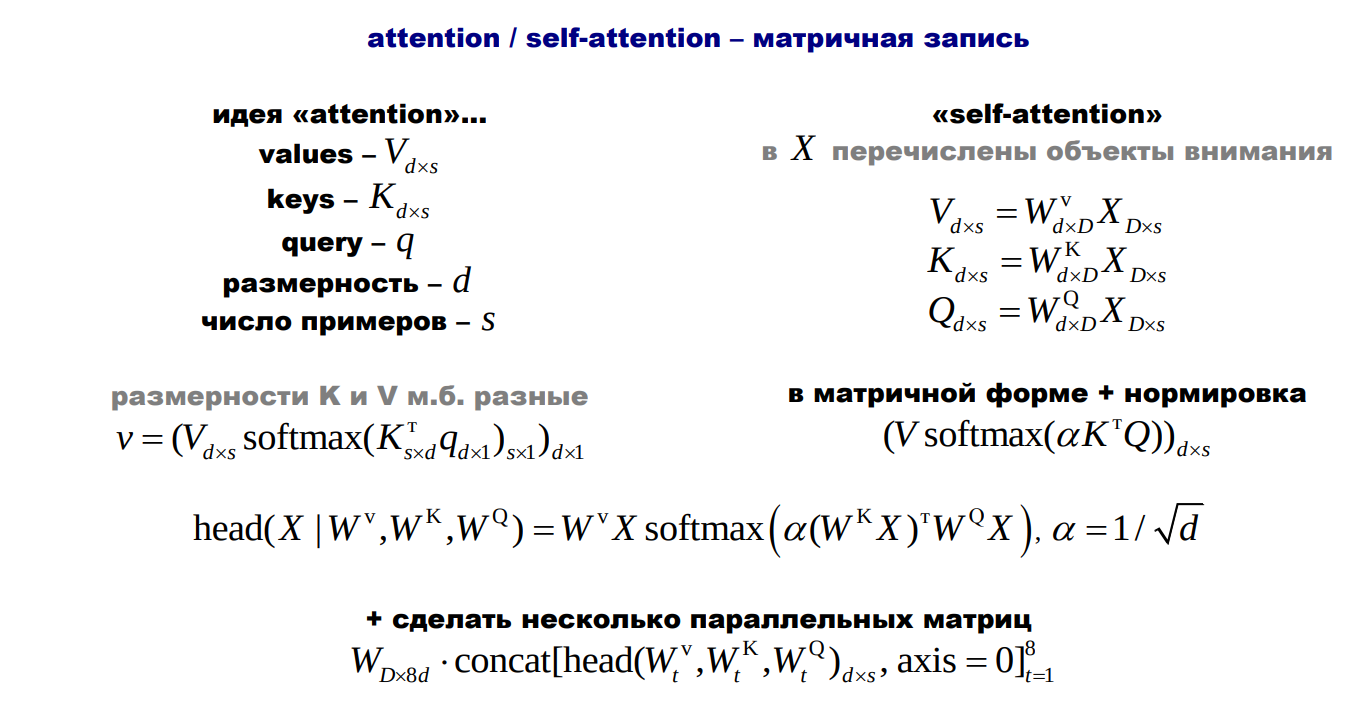

gist: http://jalammar.github.io/illustrated-transformer/

1. calculate queries, keys and values vectors (s different embeddings of each word in a sentence)
2. calculate attention scores (dot product of queries and keys) (and possibly scale)
   1. for each word, attention score is the product of its query with all keys
   2. then we simply scale each vector by dividing by sqrt(d_k)
   3. attention score is simply a number (scalar) because it is the dot product of the key and a value
   4. attention score is then softmaxed to get attention 
3. calculate attention weights by applying softmax (over each word) -> this normalizes the attention scores to be in the range of 0 and 1 and adds up to 1 (because it is softmax and not a sigmoid)
4. multiply each attention weight with each value -> sum to get the output `z` (a vector) for a particular word


When have multiple heads
1. concatenate the outputs of each head
2. multiply with a weight matrix to get the final output (to change the dimension back to the original dimension)


To encode the positions either
1. add sin/cos to the embedding vector
2. concatenate the position embedding to the word embedding vector

kotenkov https://www.youtube.com/watch?v=iOrNbK2T92M